In [1]:
%matplotlib inline
%config IPCompleter.greedy=True

import copy
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math as math
import scipy.stats as st
import auxiliary_functions as aux
import dfa_functions as dfaf
from scipy.optimize import curve_fit


pd.options.display.max_rows = 10

# Run the script to load the data (the series and their segmentation) and to delete all segments with indeterminate stage or whose max frequency is below 85%
from load_data import load_data, redo_classification
data, seg_res = load_data(filter = 0)
# Reclassificates the segments using the 4 stage system.
seg_res = redo_classification(seg_res, data)


In [2]:
g = 1
ind = 13
serie = 2

colors  = ["gold", "lightsteelblue", "orchid", "lightcoral"]
t_serie = ["Serie 0", "Serie 1", "Serie 2", "Serie 3"]
t_serie_nome = ["SBP", "DBP", "BBI-BP (ms)", "BBI-KG (ms)"]
t_grupo = ["Hypertensive", "Normotensive", "Proband"]

series = data[g][ind][t_serie[serie]]
seg_end_points = list(np.int64(seg_res[g][ind][serie]["finish"].values))
profile = np.cumsum(series - np.mean(series))

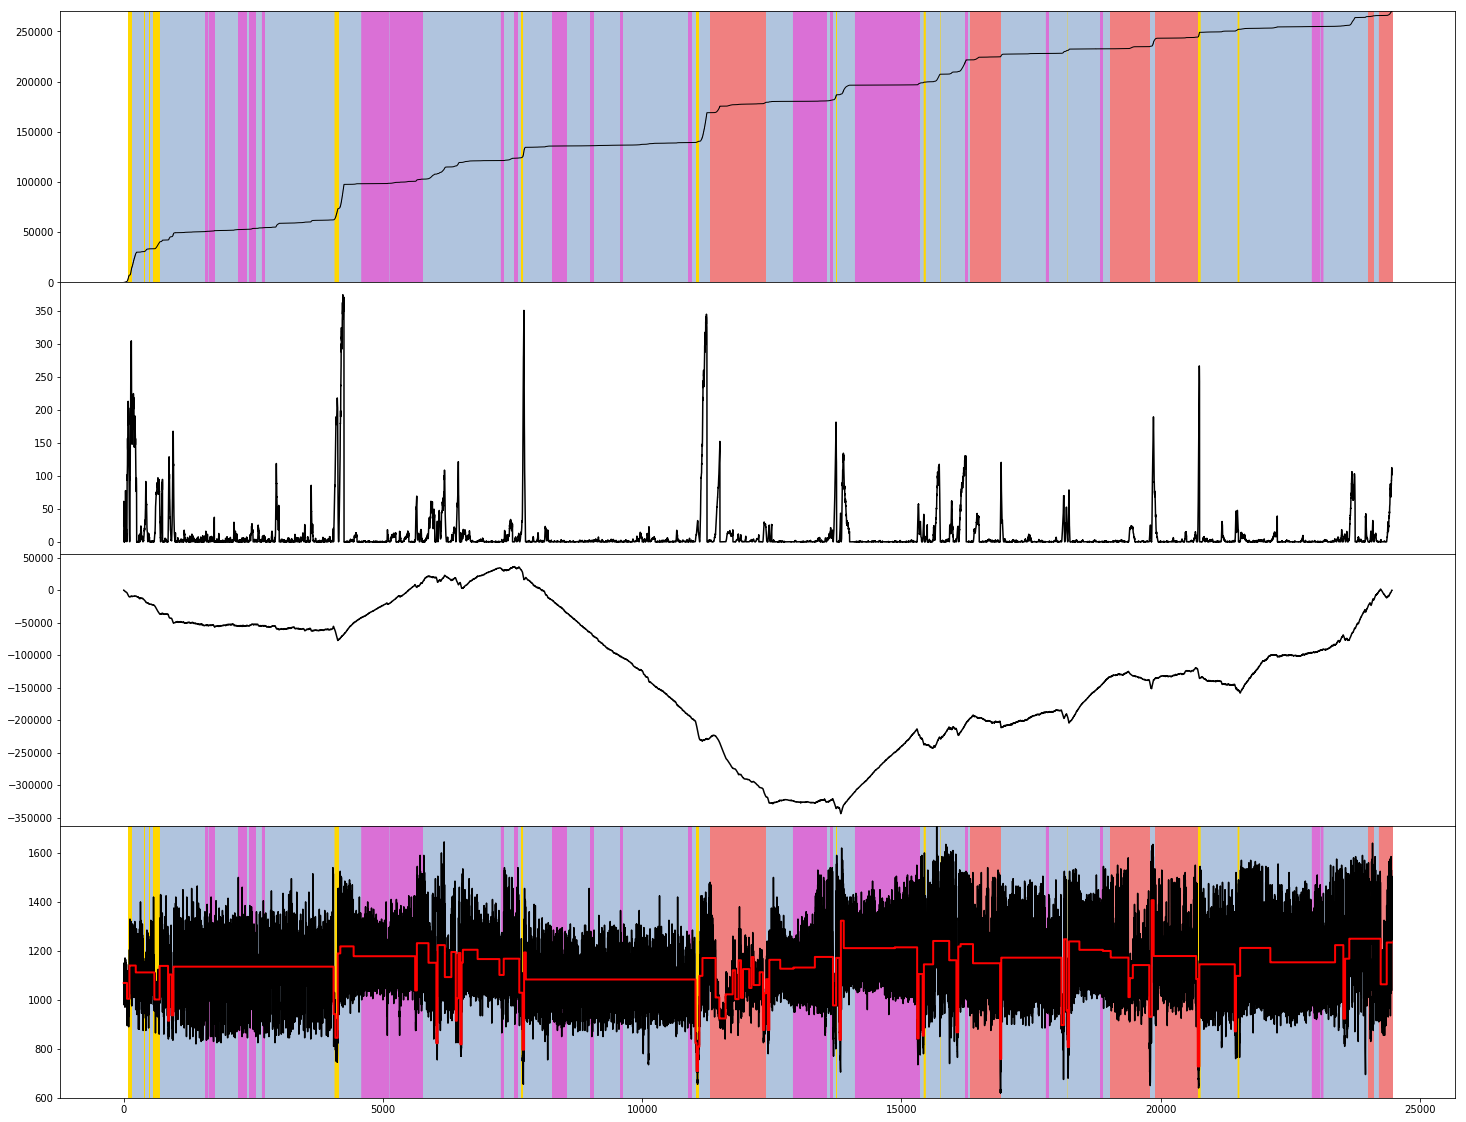

In [3]:
fig, ax = plt.subplots(ncols = 1, nrows = 4)
ax[0].set_xticks([])
ax[1].set_xticks([])
fig.set_size_inches(25, 20)
fig.subplots_adjust(hspace = 0)

for i in range(4):
    aux.axvlines(data[g][ind][data[g][ind]["SleepStage"] == float(i)].index, colors[i], 10**6, ax = ax[0])

for n in [250]:
    P = dfaf.PDFA(series, n, 1)   
    ax[0].plot(np.arange(len(P)), P, 'k', linewidth = 1, drawstyle = 'steps-post')
    
ax[0].set_ylim(0, int(P.max()) + 10)

dP = np.diff(P)
ax[1].plot(np.arange(len(dP)), dP, 'k')

max_val = series.max()
min_val = series.min()

for i in range(4):
    aux.axvlines(data[g][ind][data[g][ind]["SleepStage"] == float(i)].index, colors[i], series.max(), ax = ax[3])    
    
ax[2].plot(np.arange(len(profile)), profile, 'k')

ax[3].set_ylim(int(min_val) - 20, int(max_val))
ax[3].plot(np.arange(len(series)), series, 'k')

means = np.zeros(0)
result = seg_res[g][ind][serie]
for i in result.index:
    size = int(result.loc[i,'finish'] - result.loc[i, 'start'] + 1)
    vec = np.full([size], result.loc[i, 'mean'])
    means = np.concatenate((means,vec))
    
ax[3].plot(np.arange(len(means)), means, 'r-', linewidth = 2, drawstyle='steps-post', label='step-post')

#### Modified PDFA

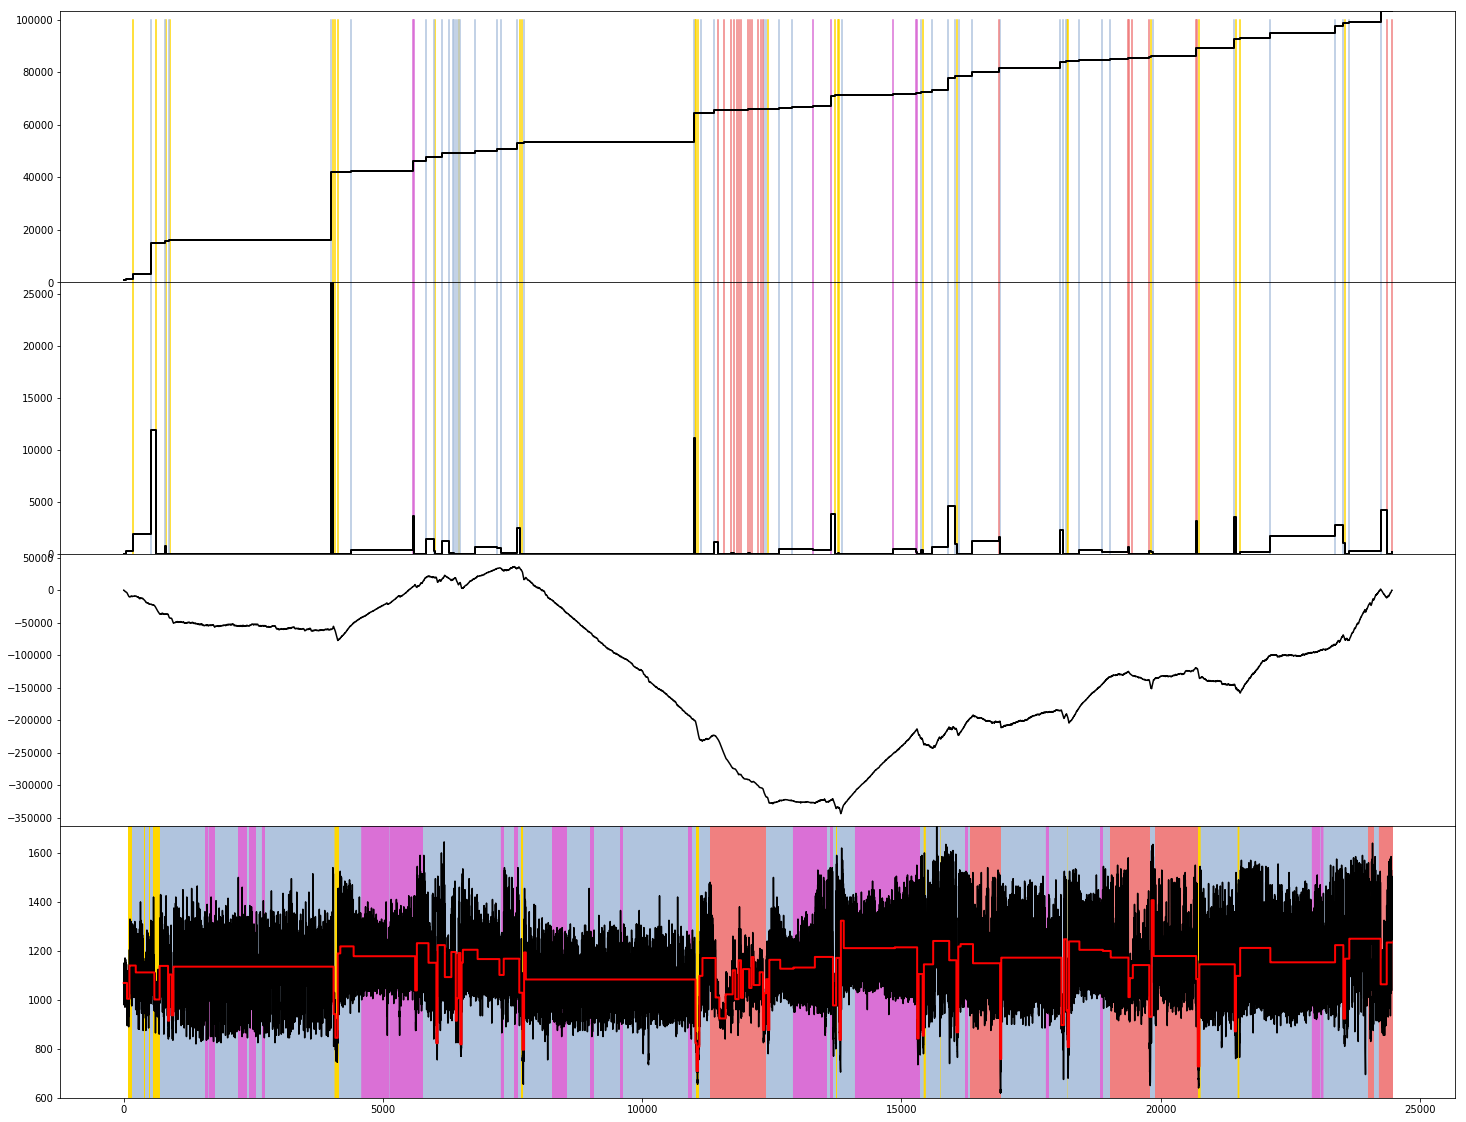

In [5]:
fig, ax = plt.subplots(ncols = 1, nrows = 4)
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])
fig.set_size_inches(25, 20)
fig.subplots_adjust(hspace = 0)

for i in [0, 1, 2, 3]:
    aux.axvlines(seg_res[g][ind][serie][seg_res[g][ind][serie]["SleepStage"] == i]["finish"], colors[i], 10**5, ax = ax[0])
    aux.axvlines(seg_res[g][ind][serie][seg_res[g][ind][serie]["SleepStage"] == i]["finish"], colors[i], 10**5, ax = ax[1])

for n in [250]:
    P = dfaf.PDFA_modified(series, seg_end_points, n, 1)   
    ax[0].plot(seg_end_points, P, 'k', linewidth = 2, drawstyle = 'steps-post')
ax[0].set_ylim(0, int(P.max()) + 10)

dP = np.diff(P)
ax[1].plot(seg_end_points, np.concatenate((np.zeros(1), dP)), 'k', linewidth = 2, drawstyle = 'steps-post')
ax[1].set_ylim(-10, int(dP.max()) + 10)

max_val = series.max()
min_val = series.min()
for i in range(4):
    aux.axvlines(data[g][ind][data[g][ind]["SleepStage"] == float(i)].index, colors[i], series.max(), ax = ax[3])    
    
ax[2].plot(np.arange(len(profile)), profile, 'k')
ax[3].set_ylim(int(min_val) - 20, int(max_val))
ax[3].plot(np.arange(len(series)), series, 'k')

means = np.zeros(0)
result = seg_res[g][ind][serie]
for i in result.index:
    size = int(result.loc[i,'finish'] - result.loc[i, 'start'] + 1)
    vec = np.full([size], result.loc[i, 'mean'])
    means = np.concatenate((means,vec))
    
ax[3].plot(np.arange(len(means)), means, 'r-', linewidth = 2, drawstyle='steps-post', label='step-post')

Text(0, 0.5, 'log (L)')

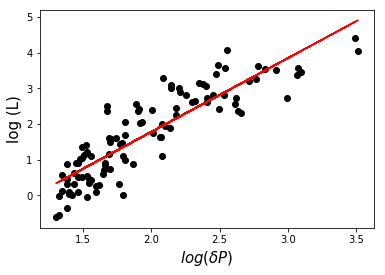

In [7]:
from scipy.optimize import curve_fit
def line(x, a, b):
    return a*x + b
sizes = seg_res[g][ind][serie]["size"]
fig, ax = plt.subplots(nrows = 1, ncols = 1)

b = np.log10(np.concatenate((np.ones(1), dP)) )
a = np.log10(sizes)
ax.scatter( a, b , color = 'k')
poly = np.polyfit(a, b, 1)
ax.plot(a, line(a, poly[0], poly[1]), 'r')

ax.set_xlabel(r'$log (\delta P)$', size = 15)
ax.set_ylabel(r'log (L)', size = 15)
#ax.set_yscale("log"); ax.set_xscale("log")
